In [ ]:
#Step 0: Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.theta import ThetaForecaster
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#Step 1: Load Data
#Serie de tiempo de vuelos aereos de pasajeros
df_raw = sns.load_dataset("flights")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [ ]:
df_raw #En automático se ordena por los primeros y ultimos cinco

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [ ]:
#Step 2: Preprocessing
#Convertir ese mes y año en fecha
df_baking = df_raw.copy()
df_baking['month'] = pd.to_datetime(df_baking['month'], format="%b").dt.month #Formato de abreviatura mes
df_baking['year'] = pd.to_datetime(df_baking['year'], format="%Y").dt.year #Formato de abreviatura año
df_baking['date'] = pd.to_datetime(df_baking[['year','month']].assign(day = 1)) + pd.offsets.MonthEnd(1)
df_baking = df_baking.drop(columns=['year','month'])
df_baking = df_baking.set_index('date')

df = df_baking['passengers'].copy()
df = df.resample('ME').sum()
df


,passengers
date,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461


In [ ]:
#Step 3: EDA
display(df.to_frame().reset_index().describe().T)

,count,mean,min,25%,50%,75%,max,std
date,144,1955-01-14 15:30:00,1949-01-31 00:00:00,1952-01-23 06:00:00,1955-01-15 12:00:00,1958-01-07 18:00:00,1960-12-31 00:00:00,NaN
passengers,144.0,280.298611,104.0,180.0,265.5,360.5,622.0,119.966317


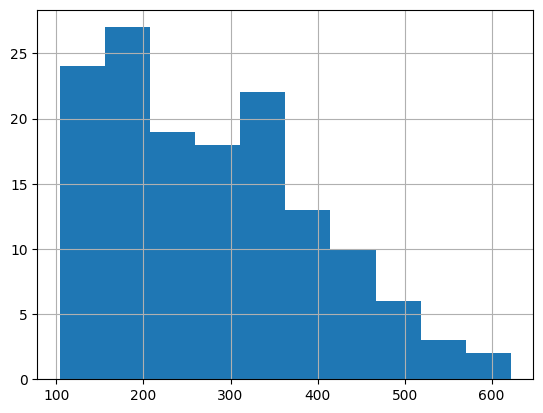

In [ ]:
df.hist()
plt.show()

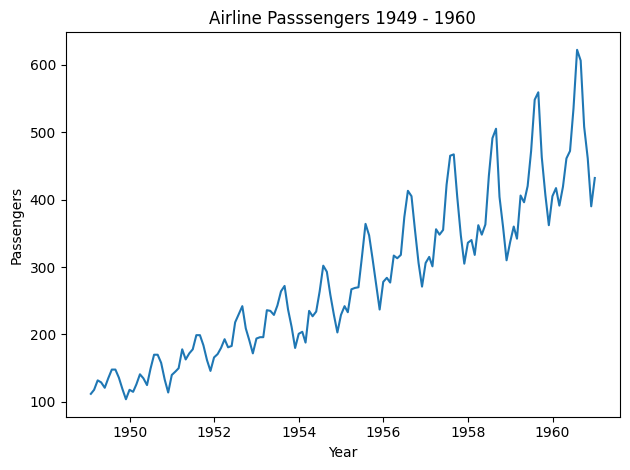

In [ ]:
plt.plot(df)
plt.title("Airline Passsengers 1949 - 1960")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.tight_layout()
plt.show()

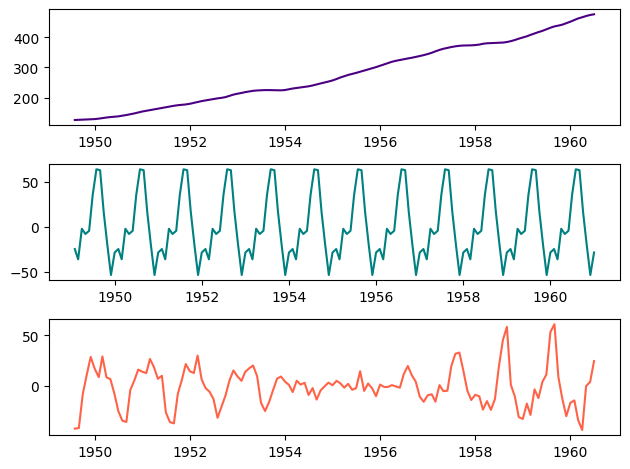

In [ ]:
descomposition = seasonal_decompose(df)
trend = descomposition.trend
seasonal = descomposition.seasonal
residual = descomposition.resid

fig,ax= plt.subplots(3,1)
ax[0].plot(trend, c='indigo')
ax[1].plot(seasonal, c='teal')
ax[2].plot(residual, c='tomato')

plt.tight_layout()
plt.show()


In [ ]:
test_dfuller= adfuller(df)
print(f'test Dickey_Fuller: {test_dfuller[0]:.2f}')
print(f'test p_value: {test_dfuller[1]:.2f}')

test Dickey_Fuller: 0.82
test p_value: 0.99


In [ ]:
df_1diff = df.diff(1).dropna()
test_dfuller= adfuller(df_1diff)
print(f'test Dickey_Fuller: {test_dfuller[0]:.2f}')
print(f'test p_value: {test_dfuller[1]:.2f}')

test Dickey_Fuller: -2.83
test p_value: 0.05


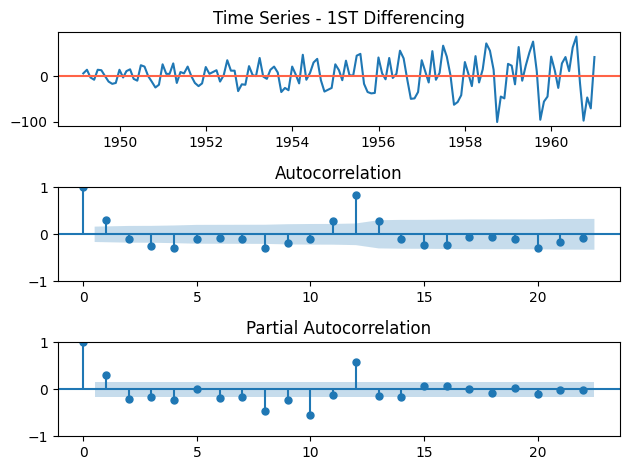

In [ ]:
fig, ax =plt.subplots(3,1)
ax[0].plot(df_1diff)
ax[0].axhline(y=0,c='tomato')
ax[0].set_title('Time Series - 1ST Differencing')
plot_acf(df_1diff, ax=ax[1])
plot_pacf(df_1diff, ax=ax[2])
plt.tight_layout()
plt.show()

In [ ]:
grid=[]
for p in range(3):
  for d in range(2):
    for q in range(2):
      for P in range(3):
        for D in range(3):
          for Q in range(3):
            temp_model = sm.tsa.SARIMAX(df, order=(p,d,q), seasonal_order=(P,D,Q,12),
                                        enforce_invertibility=False,
                                        enforce_stationarity=False ) #Cada 12 meses se cumple el ciclo
            results = temp_model.fit()
            orders = f'{p}_{d}_{q}_{P}_{D}_{Q}'
            grid.append((orders,float(results.aic)))



/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
sorted(grid, key=lambda x: x[1])[:5]

[('0_1_1_0_2_2', 730.844800510141),
 ('0_1_1_1_2_2', 732.7758118530764),
 ('1_1_1_0_2_2', 732.8024536816861),
 ('2_1_1_0_2_2', 732.976798205301),
 ('0_1_1_2_2_2', 733.9666398088541)]

In [ ]:
model = sm.tsa.SARIMAX(df, order=(0,1,1), seasonal_order=(0,2,2,12))
results = model.fit()
results.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -465.023
Date:                                 Tue, 07 Oct 2025   AIC                            938.046
Time:                                         01:49:09   BIC                            949.163
Sample:                                     01-31-1949   HQIC                           942.561
                                          - 12-31-1960                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4758      0.066     -7.157      0.000      -0.606      -0.345
ma.S.L12      -1.3523      0.206     -6.568      0.000      -1.756      -0.949
ma.S.L24       0.4204      0.112      3.739      0.000       0.200       0.641
sigma2       110.5701     21.613      5.116      0.000      68.210     152.931
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 6.18
Prob(Q):                              0.85   Prob(JB):                         0.05
Heteroskedasticity (H):               2.36   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
horizon = 36
forecast = results.get_forecast(horizon)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

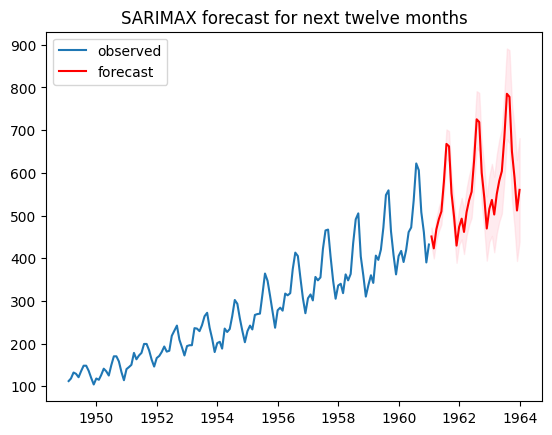

In [ ]:
plt.plot(df, label="observed")
plt.plot(forecast_mean, c="r", label="forecast")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="pink", alpha=0.3)
plt.legend()
plt.title("SARIMAX forecast for next twelve months")
plt.show()

Logramos hacer una grafica con un intervalo de confianza que nos permite saber cuanto vamos a fallar en nuestra prediccion, mientras mas lejos el intervalo de confianza se eleva debido a que mientras mas tiempo pase, es mas dificil predecir lo que pueda pasar en el futuro